In [0]:
%matplotlib inline
import warnings
import seaborn as sns
warnings.filterwarnings('ignore')
#import the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score,confusion_matrix, classification_report,roc_auc_score
from scipy.stats import zscore
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [0]:
from google.colab import drive

In [3]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import pandas as pd
df = pd.read_csv('/content/drive/My Drive/Colab/vehicles.csv')
df.head()

,compactness,circularity,distance_circularity,radius_ratio,pr.axis_aspect_ratio,max.length_aspect_ratio,scatter_ratio,elongatedness,pr.axis_rectangularity,max.length_rectangularity,scaled_variance,scaled_variance.1,scaled_radius_of_gyration,scaled_radius_of_gyration.1,skewness_about,skewness_about.1,skewness_about.2,hollows_ratio,class
0,95,48.0,83.0,178.0,72.0,10,162.0,42.0,20.0,159,176.0,379.0,184.0,70.0,6.0,16.0,187.0,197,van
1,91,41.0,84.0,141.0,57.0,9,149.0,45.0,19.0,143,170.0,330.0,158.0,72.0,9.0,14.0,189.0,199,van
2,104,50.0,106.0,209.0,66.0,10,207.0,32.0,23.0,158,223.0,635.0,220.0,73.0,14.0,9.0,188.0,196,car
3,93,41.0,82.0,159.0,63.0,9,144.0,46.0,19.0,143,160.0,309.0,127.0,63.0,6.0,10.0,199.0,207,van
4,85,44.0,70.0,205.0,103.0,52,149.0,45.0,19.0,144,241.0,325.0,188.0,127.0,9.0,11.0,180.0,183,bus


In [5]:
df['class'].unique()

array(['van', 'car', 'bus'], dtype=object)

# 1. Data pre-processing - Understand the data and treat missing values (Use box plot), outliers (5  points) 

In [6]:
df.shape

(846, 19)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 846 entries, 0 to 845
Data columns (total 19 columns):
compactness                    846 non-null int64
circularity                    841 non-null float64
distance_circularity           842 non-null float64
radius_ratio                   840 non-null float64
pr.axis_aspect_ratio           844 non-null float64
max.length_aspect_ratio        846 non-null int64
scatter_ratio                  845 non-null float64
elongatedness                  845 non-null float64
pr.axis_rectangularity         843 non-null float64
max.length_rectangularity      846 non-null int64
scaled_variance                843 non-null float64
scaled_variance.1              844 non-null float64
scaled_radius_of_gyration      844 non-null float64
scaled_radius_of_gyration.1    842 non-null float64
skewness_about                 840 non-null float64
skewness_about.1               845 non-null float64
skewness_about.2               845 non-null float64
hollows_ratio    

In [8]:
df.isnull().sum()

compactness                    0
circularity                    5
distance_circularity           4
radius_ratio                   6
pr.axis_aspect_ratio           2
max.length_aspect_ratio        0
scatter_ratio                  1
elongatedness                  1
pr.axis_rectangularity         3
max.length_rectangularity      0
scaled_variance                3
scaled_variance.1              2
scaled_radius_of_gyration      2
scaled_radius_of_gyration.1    4
skewness_about                 6
skewness_about.1               1
skewness_about.2               1
hollows_ratio                  0
class                          0
dtype: int64

As seen above,the data frame shape is(846, 19),the target column is class and the columns compactness,max.length_aspect_ratio,max.length_rectangularity,hollows_ratio have no missing values,rest all columns have some missing values.

Separating numerical and categorical cols to treat the missing values and encoding

In [0]:
categoricalCols = df['class']

numericalCols = df[['compactness', 'circularity', 'distance_circularity', 'radius_ratio',
       'pr.axis_aspect_ratio', 'max.length_aspect_ratio', 'scatter_ratio',
       'elongatedness', 'pr.axis_rectangularity', 'max.length_rectangularity',
       'scaled_variance', 'scaled_variance.1', 'scaled_radius_of_gyration',
       'scaled_radius_of_gyration.1', 'skewness_about', 'skewness_about.1',
       'skewness_about.2', 'hollows_ratio']]

In [0]:
from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
numericalCols = pd.DataFrame(imp.fit_transform(numericalCols), columns = numericalCols.columns)

In [0]:
newdf = pd.concat([numericalCols, categoricalCols], axis = 1)

In [12]:
from sklearn.preprocessing import LabelEncoder 
le = LabelEncoder() 
newdf['class'] = le.fit_transform(newdf['class'])
newdf.head()

,compactness,circularity,distance_circularity,radius_ratio,pr.axis_aspect_ratio,max.length_aspect_ratio,scatter_ratio,elongatedness,pr.axis_rectangularity,max.length_rectangularity,scaled_variance,scaled_variance.1,scaled_radius_of_gyration,scaled_radius_of_gyration.1,skewness_about,skewness_about.1,skewness_about.2,hollows_ratio,class
0,95.0,48.0,83.0,178.0,72.0,10.0,162.0,42.0,20.0,159.0,176.0,379.0,184.0,70.0,6.0,16.0,187.0,197.0,2
1,91.0,41.0,84.0,141.0,57.0,9.0,149.0,45.0,19.0,143.0,170.0,330.0,158.0,72.0,9.0,14.0,189.0,199.0,2
2,104.0,50.0,106.0,209.0,66.0,10.0,207.0,32.0,23.0,158.0,223.0,635.0,220.0,73.0,14.0,9.0,188.0,196.0,1
3,93.0,41.0,82.0,159.0,63.0,9.0,144.0,46.0,19.0,143.0,160.0,309.0,127.0,63.0,6.0,10.0,199.0,207.0,2
4,85.0,44.0,70.0,205.0,103.0,52.0,149.0,45.0,19.0,144.0,241.0,325.0,188.0,127.0,9.0,11.0,180.0,183.0,0


#The distribution of the variables

Univariant analysis

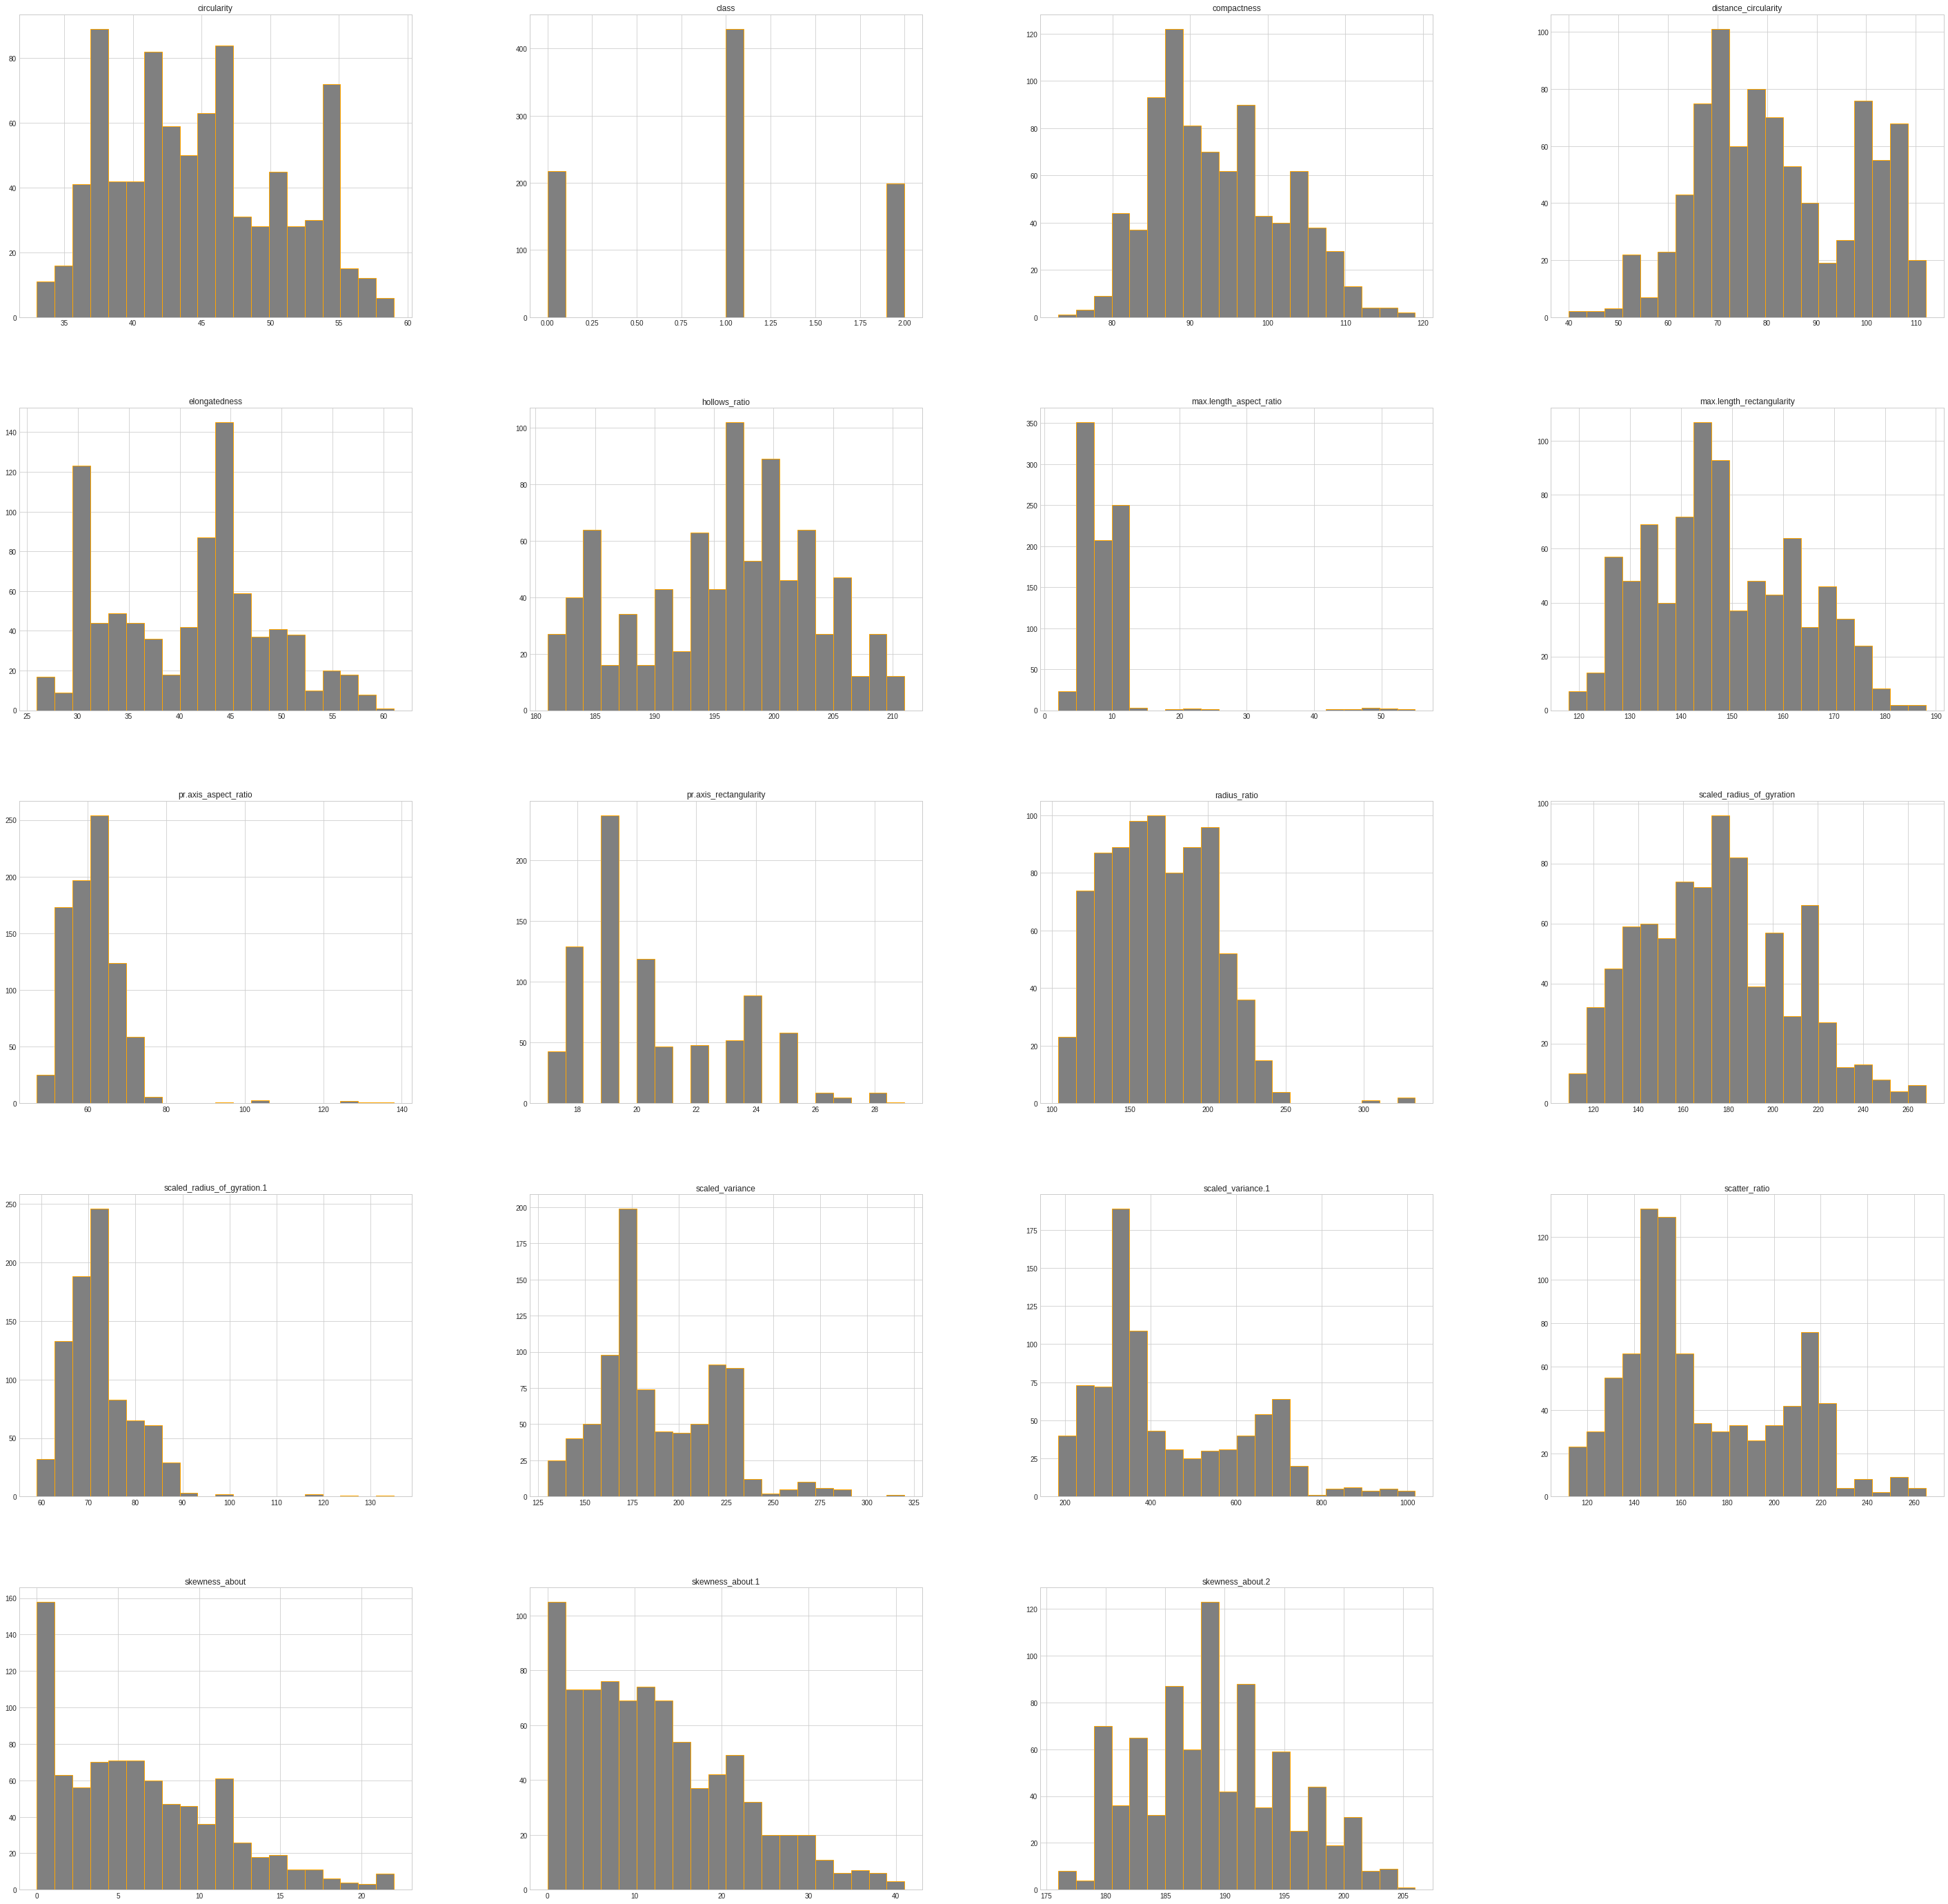

In [13]:
plt.style.use('seaborn-whitegrid')
newdf.hist(bins=20, figsize=(50,50), color='grey', edgecolor = 'orange')
plt.show()

* Most of the attributes are normally distributed
* skewness_about,skewness_about.1,skewness_about.2,scaled_variance,scaled_variance.1 seem to have a right skewed distribution
* pr.axis_aspect_ratio,radius_ratio,scaled_radius_of_gyration seem to have outliers

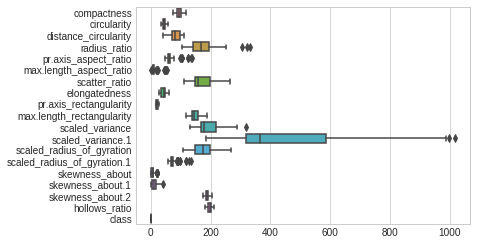

In [14]:
ax = sns.boxplot(data=newdf, orient="h")

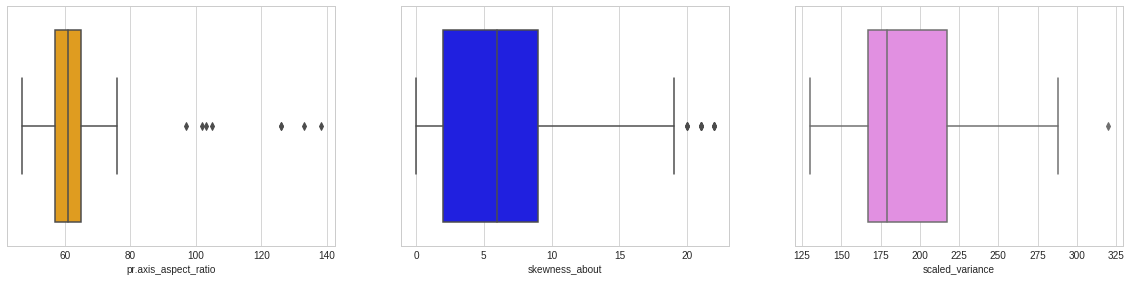

In [15]:
plt.figure(figsize= (20,15))
plt.subplot(3,3,1)
sns.boxplot(x= newdf['pr.axis_aspect_ratio'], color='orange')
plt.subplot(3,3,2)
sns.boxplot(x= newdf.skewness_about, color='blue')
plt.subplot(3,3,3)
sns.boxplot(x= newdf.scaled_variance, color='violet')
plt.show()

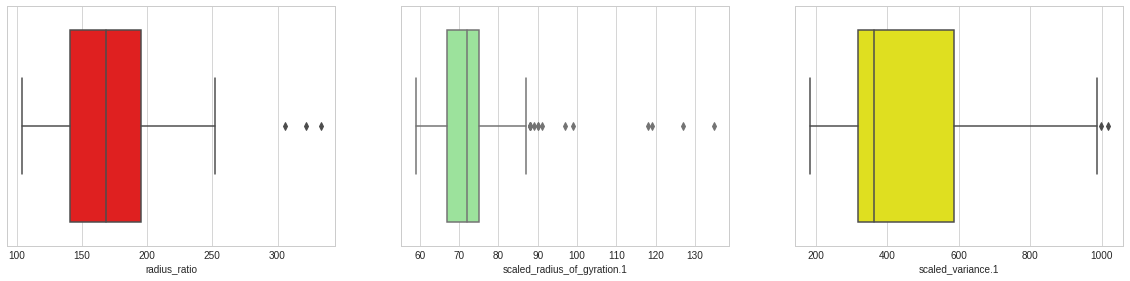

In [16]:
plt.figure(figsize= (20,15))
plt.subplot(3,3,1)
sns.boxplot(x= newdf['radius_ratio'], color='red')
plt.subplot(3,3,2)
sns.boxplot(x= newdf['scaled_radius_of_gyration.1'], color='lightgreen')
plt.subplot(3,3,3)
sns.boxplot(x= newdf['scaled_variance.1'], color='yellow')
plt.show()

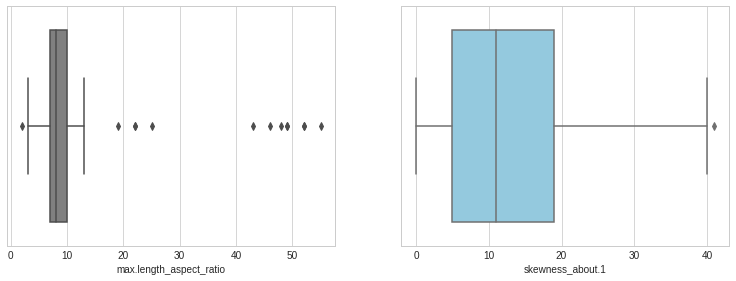

In [17]:
plt.figure(figsize= (20,15))
plt.subplot(3,3,1)
sns.boxplot(x= newdf['max.length_aspect_ratio'], color='grey')
plt.subplot(3,3,2)
sns.boxplot(x= newdf['skewness_about.1'], color='skyblue')
plt.show()

From the box plot we are able to see outliers in many attributes,lets treat them

In [18]:
from scipy.stats import iqr
Q1 = newdf.quantile(0.25)
Q3 = newdf.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

compactness                     13.00
circularity                      9.00
distance_circularity            28.00
radius_ratio                    54.00
pr.axis_aspect_ratio             8.00
max.length_aspect_ratio          3.00
scatter_ratio                   51.00
elongatedness                   13.00
pr.axis_rectangularity           4.00
max.length_rectangularity       22.00
scaled_variance                 50.00
scaled_variance.1              268.50
scaled_radius_of_gyration       49.00
scaled_radius_of_gyration.1      8.00
skewness_about                   7.00
skewness_about.1                14.00
skewness_about.2                 9.00
hollows_ratio                   10.75
class                            1.00
dtype: float64


New dataframe without outliers 

In [19]:
df1 = newdf[~((newdf < (Q1 - 1.5 * IQR)) |(newdf > (Q3 + 1.5 * IQR))).any(axis=1)]
df1.shape

(813, 19)

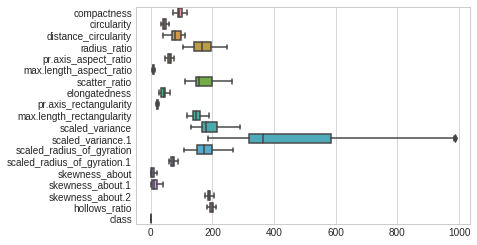

In [20]:
ax = sns.boxplot(data=df1, orient="h")

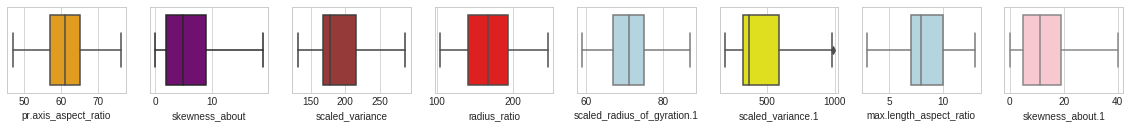

In [21]:
plt.figure(figsize= (20,15))
plt.subplot(8,8,1)
sns.boxplot(x= df1['pr.axis_aspect_ratio'], color='orange')
plt.subplot(8,8,2)
sns.boxplot(x= df1.skewness_about, color='purple')
plt.subplot(8,8,3)
sns.boxplot(x= df1.scaled_variance, color='brown')
plt.subplot(8,8,4)
sns.boxplot(x= df1['radius_ratio'], color='red')
plt.subplot(8,8,5)
sns.boxplot(x= df1['scaled_radius_of_gyration.1'], color='lightblue')
plt.subplot(8,8,6)
sns.boxplot(x= df1['scaled_variance.1'], color='yellow')
plt.subplot(8,8,7)
sns.boxplot(x= df1['max.length_aspect_ratio'], color='lightblue')
plt.subplot(8,8,8)
sns.boxplot(x= df1['skewness_about.1'], color='pink')
plt.show()

Bivariate analysis

In [22]:
corr=df1.corr()
corr

,compactness,circularity,distance_circularity,radius_ratio,pr.axis_aspect_ratio,max.length_aspect_ratio,scatter_ratio,elongatedness,pr.axis_rectangularity,max.length_rectangularity,scaled_variance,scaled_variance.1,scaled_radius_of_gyration,scaled_radius_of_gyration.1,skewness_about,skewness_about.1,skewness_about.2,hollows_ratio,class
compactness,1.000000,0.679901,0.786810,0.746091,0.200887,0.497660,0.810430,-0.788449,0.811810,0.674166,0.792230,0.814537,0.577596,-0.254274,0.200199,0.161505,0.295404,0.364160,-0.028066
circularity,0.679901,1.000000,0.787513,0.641013,0.205616,0.563732,0.844049,-0.816212,0.841827,0.961873,0.803324,0.835218,0.926273,0.067633,0.140639,-0.014774,-0.118122,0.038081,-0.151426
distance_circularity,0.786810,0.787513,1.000000,0.808392,0.245423,0.668662,0.904856,-0.908822,0.894892,0.768843,0.884633,0.889593,0.702683,-0.237766,0.098711,0.263514,0.128336,0.320969,-0.058983
radius_ratio,0.746091,0.641013,0.808392,1.000000,0.666403,0.460737,0.789305,-0.844374,0.763736,0.577067,0.793528,0.778087,0.550726,-0.403672,0.040348,0.187295,0.418257,0.504630,-0.225840
pr.axis_aspect_ratio,0.200887,0.205616,0.245423,0.666403,1.000000,0.138243,0.199988,-0.302280,0.169522,0.146175,0.215642,0.187041,0.153722,-0.325331,-0.051643,-0.028793,0.406247,0.419789,-0.216783
max.length_aspect_ratio,0.497660,0.563732,0.668662,0.460737,0.138243,1.000000,0.497043,-0.502220,0.497641,0.647844,0.411749,0.459248,0.404216,-0.333074,0.083734,0.141178,0.056225,0.394449,0.371072
scatter_ratio,0.810430,0.844049,0.904856,0.789305,0.199988,0.497043,1.000000,-0.971404,0.989034,0.806303,0.977143,0.993807,0.794274,0.001917,0.063319,0.214919,-0.003595,0.115782,-0.283371
elongatedness,-0.788449,-0.816212,-0.908822,-0.844374,-0.302280,-0.502220,-0.971404,1.000000,-0.950026,-0.769684,-0.965252,-0.957135,-0.762109,0.087179,-0.044795,-0.184625,-0.104837,-0.210884,0.337823
pr.axis_rectangularity,0.811810,0.841827,0.894892,0.763736,0.169522,0.497641,0.989034,-0.950026,1.000000,0.810894,0.964170,0.989139,0.792606,0.017604,0.071871,0.216661,-0.026842,0.097842,-0.251222
max.length_rectangularity,0.674166,0.961873,0.768843,0.577067,0.146175,0.647844,0.806303,-0.769684,0.810894,1.000000,0.749909,0.795560,0.866913,0.052080,0.134511,-0.002135,-0.117988,0.067177,-0.025047


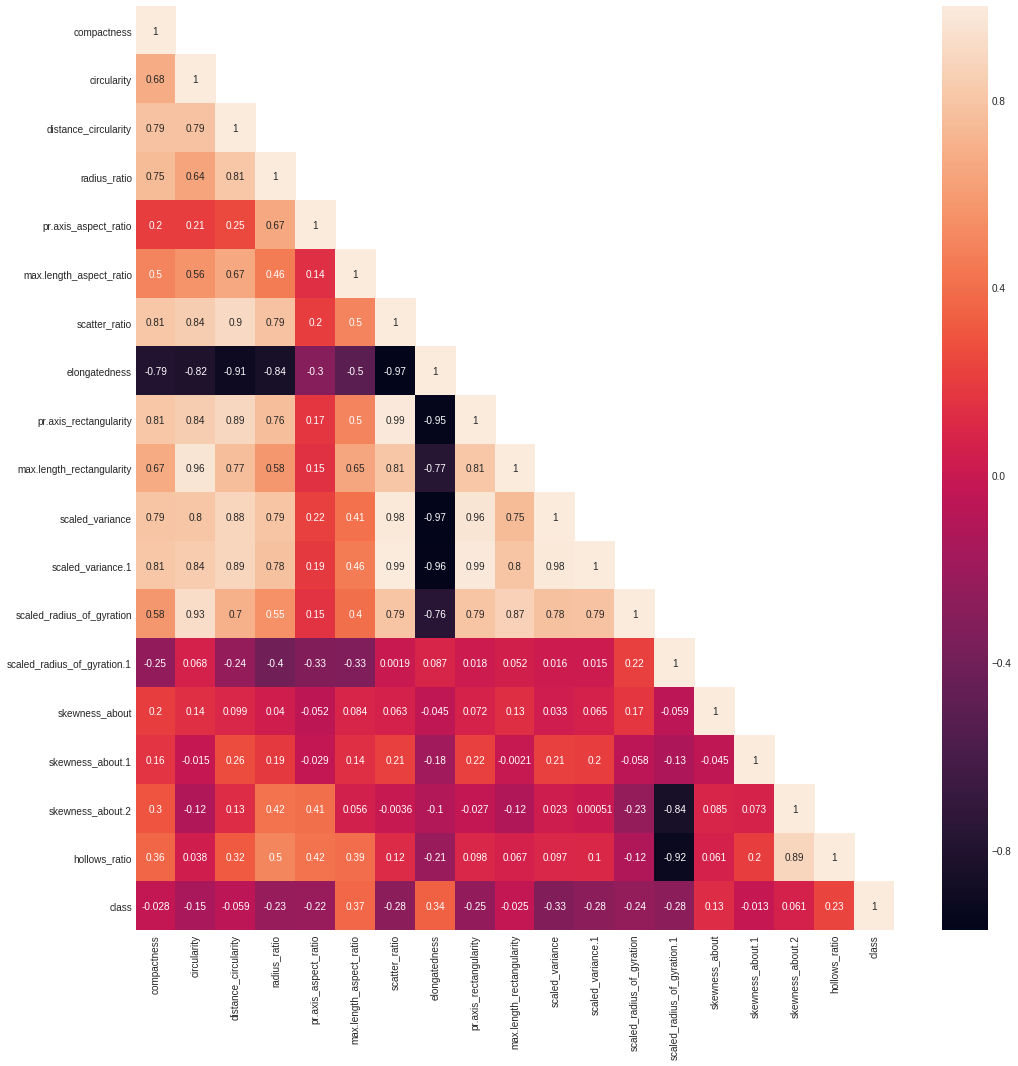

In [23]:
plt.figure(figsize=(17,17))
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask, 1)] = True
sns.heatmap(corr,mask= mask,annot = True)

In [24]:
sns.pairplot(df1, diag_kind='kde')

Output hidden; open in https://colab.research.google.com to view.

**Most of the independent attributes are strongly co-related which leads to "Multicollinearity"**

# Target Distribution

In [25]:
 df1['class'].value_counts()

1    416
0    208
2    189
Name: class, dtype: int64

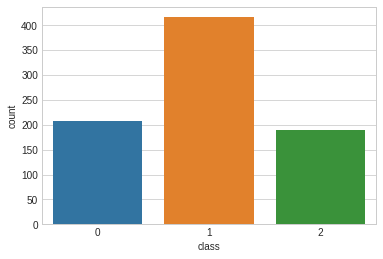

In [26]:
sns.countplot(df1['class'])
plt.show()

# 3. Use PCA from scikit learn and elbow plot to find out a reduced number of dimension (which  covers more than 95% of the variance) - 10 points 

**Splitting the data into train and test and apply PCA**

In [0]:
X = df1.drop(["class"] , axis=1)
y=df1["class"]

In [0]:
test_size = 0.30
seed = 7 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

**Scaling:**

In [29]:
X_train= StandardScaler().fit_transform(X_train)
X_test= StandardScaler().fit_transform(X_test)
print(len(X_train))
print(len(X_test))

569
244


**Covariance matrix:**

In [30]:
# generating the covariance matrix and the eigenvalues for the PCA analysis
cov_matrix_1 = np.cov(X_train.T) # the relevant covariance matrix
print('Covariance Matrix \n%s', (cov_matrix_1))
#generating the eigenvalues and the eigenvectors
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix_1)
print('Eigenvectors \n%s' %(eigenvectors))
print('\nEigenvalues \n%s' %eigenvalues)


Covariance Matrix 
%s [[ 1.00176056e+00  6.78620814e-01  7.82064942e-01  7.38539516e-01
   1.91511984e-01  5.06913467e-01  8.04100258e-01 -7.83371246e-01
   8.06747292e-01  6.63885045e-01  7.87198111e-01  8.08541456e-01
   5.71867624e-01 -2.78590813e-01  1.49745690e-01  1.47398963e-01
   3.00491620e-01  3.78510786e-01]
 [ 6.78620814e-01  1.00176056e+00  7.89323596e-01  6.43830793e-01
   2.01762671e-01  5.86923484e-01  8.44583109e-01 -8.16792131e-01
   8.43328542e-01  9.63107759e-01  8.01098550e-01  8.34835437e-01
   9.21997330e-01  4.77533401e-02  1.03787576e-01  7.40864752e-03
  -1.15335225e-01  5.22388667e-02]
 [ 7.82064942e-01  7.89323596e-01  1.00176056e+00  8.08144443e-01
   2.42998765e-01  6.80690465e-01  9.07045546e-01 -9.09977090e-01
   9.00336691e-01  7.65384282e-01  8.90868509e-01  8.92749676e-01
   7.03169603e-01 -2.46174446e-01  5.12838225e-02  2.70997609e-01
   1.19324391e-01  3.21180796e-01]
 [ 7.38539516e-01  6.43830793e-01  8.08144443e-01  1.00176056e+00
   6.71361103e-

**Calculating Eigen Vectors & Eigen Values: Using numpy linear algebra function:**

In [31]:
# Step 3 (continued): Sort eigenvalues in descending order
# Make a set of (eigenvalue, eigenvector) pairs
eig_pairs = [(eigenvalues[index], eigenvectors[:,index]) for index in range(len(eigenvalues))]
# Sort the (eigenvalue, eigenvector) pairs from highest to lowest with respect to eigenvalue
eig_pairs.sort()
eig_pairs.reverse()
print(eig_pairs)
# Extract the descending ordered eigenvalues and eigenvectors
eigvalues_sorted = [eig_pairs[index][0] for index in range(len(eigenvalues))]
eigvectors_sorted = [eig_pairs[index][1] for index in range(len(eigenvalues))]
# Let's confirm our sorting worked, print out eigenvalues
print('Eigenvalues in descending order: \n%s' %eigvalues_sorted)

[(9.806777766574825, array([-0.26995303, -0.28536902, -0.30152297, -0.27250298, -0.09779024,
       -0.20013479, -0.31016362,  0.30818569, -0.30791858, -0.27432815,
       -0.30318858, -0.3073775 , -0.26125948,  0.04885184, -0.02125518,
       -0.06197784, -0.03345435, -0.08479311])), (3.355373606016265, array([-0.094509  ,  0.12999728, -0.03911567, -0.20484269, -0.26773332,
       -0.07408927,  0.07284464, -0.01294701,  0.08485041,  0.12626477,
        0.06824579,  0.07590547,  0.20900408,  0.50399798, -0.00974129,
       -0.06847994, -0.50527219, -0.50664712])), (1.1853679966372102, array([ 0.05009993,  0.21164173, -0.06604569, -0.06605032,  0.0288623 ,
        0.14975775, -0.10643156,  0.09108528, -0.10225568,  0.22978768,
       -0.1413861 , -0.10687407,  0.20636615, -0.07928531,  0.58253587,
       -0.64197959,  0.0619886 ,  0.04707659])), (1.1484377465017086, array([ 1.21792879e-01, -4.19639909e-02,  1.12738776e-01, -2.37528632e-01,
       -5.86752059e-01,  3.04558130e-01,  2.461

**Sort eigenvalues in descending order**

In [0]:
tot = sum(eigenvalues)
var_explained = [(i / tot) for i in sorted(eigenvalues, reverse=True)]  # an array of variance explained by each 
# eigen vector... there will be 8 entries as there are 8 eigen vectors)
cum_var_exp = np.cumsum(var_explained)  # an array of cumulative variance. There will be 8 entries with 8 th entry 
# cumulative reaching almost 100%

**Plotting The Explained Variance and Principal Components:**

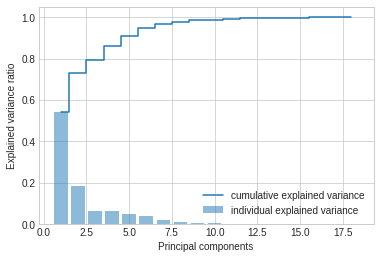

In [33]:
plt.bar(range(1,19), var_explained, alpha=0.5, align='center', label='individual explained variance')
plt.step(range(1,19),cum_var_exp, where= 'mid', label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc = 'best')
plt.show()

* From above plot we can clearly observe that 8 dimension() are able to explain 95 %variance of data.
* So we will use first 8 principal components going forward and calulate the reduced dimensions.

**Reducing Dimension: From the eigenvectors:**

In [34]:
# P_reduce represents reduced mathematical space....
P_reduce_1 = np.array(eigvectors_sorted[0:8])   # Reducing from 8 to 4 dimension space
X_train_pca = np.dot(X_train,P_reduce_1.T)   # projecting original data into principal component dimensions
X_test_pca = np.dot(X_test,P_reduce_1.T) 
#Proj_data_df_new = pd.DataFrame(X_std_8D_1)
print(X_train_pca)
print(X_test_pca)
Projected_df_train = pd.DataFrame(X_train_pca)
Projected_df_test = pd.DataFrame(X_test_pca)

[[-4.92807051  0.15278018  0.22700662 ... -0.57253612 -0.18181471
  -0.16667312]
 [ 1.16253209  0.27975057 -2.14094083 ... -0.30400503 -0.6955691
   0.21470737]
 [-2.73179025 -0.94304276  0.5969566  ...  0.99428909 -1.19587022
   0.09418481]
 ...
 [-4.43869668  0.04109747 -0.71581991 ... -0.13960532 -0.08478574
  -1.47533551]
 [-4.00887253  2.07831082  0.68851819 ...  1.28188595  0.18287529
   0.13412881]
 [ 0.36173423 -0.28140459  1.29522608 ...  0.07750462  0.29555388
  -0.21387197]]
[[-4.4522415   0.89206098  2.00051594 ... -0.36783292 -0.5258383
  -0.11431985]
 [ 1.95585875 -1.29409058  0.83461242 ... -0.2742554   0.98600092
   0.2165197 ]
 [ 4.65868422  2.47076089 -0.72444736 ... -0.01471976 -0.42842091
  -0.40643505]
 ...
 [-4.73477992 -0.96434402 -0.12196307 ...  0.04299459 -0.01255231
  -0.55453512]
 [ 1.63589253  0.90548533  1.02188101 ... -1.48862669  0.04157553
   0.53198089]
 [-1.53617884  0.31170939 -2.64004021 ...  0.44826671  0.37671533
  -0.96017134]]


**Pairplot Analysis : On Training PCA Data Set**

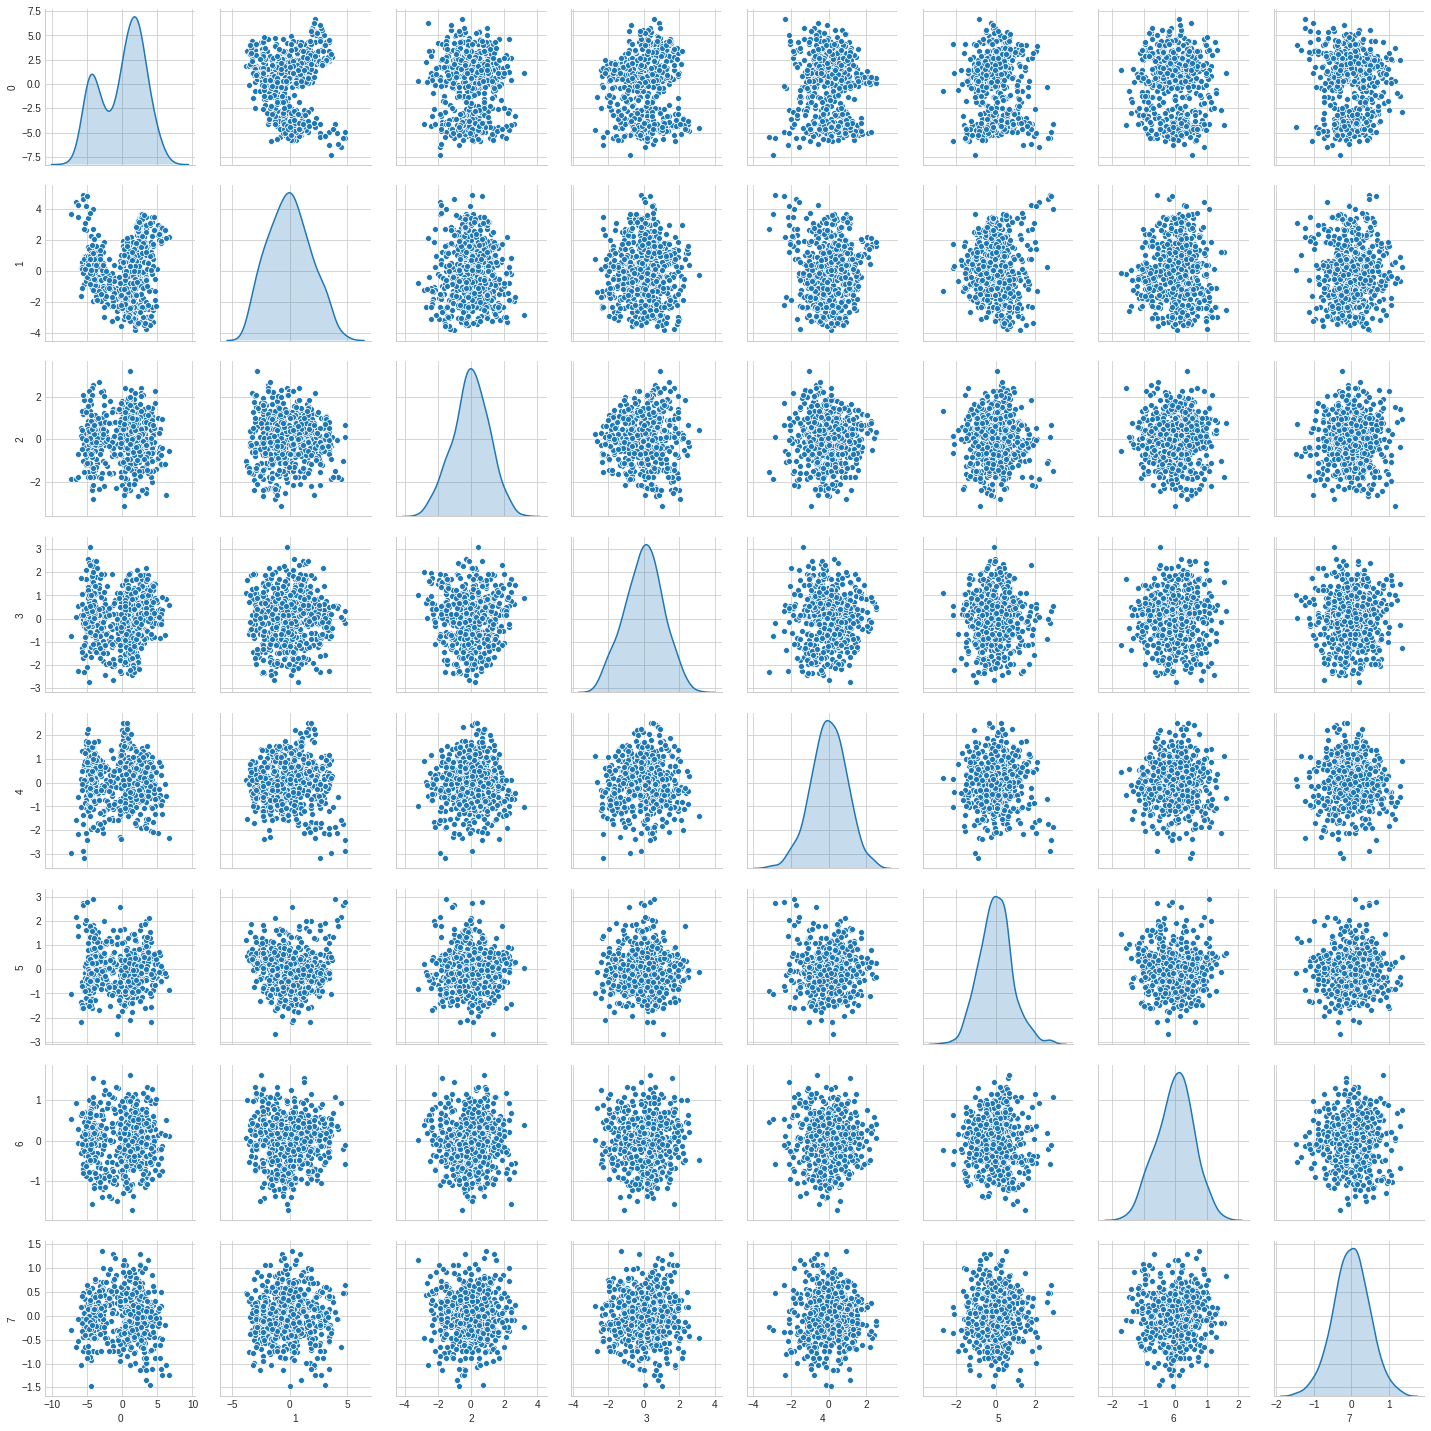

In [35]:
sns.pairplot(Projected_df_train, diag_kind='kde')

**Pairplot Analysis : On Test PCA Data Set**

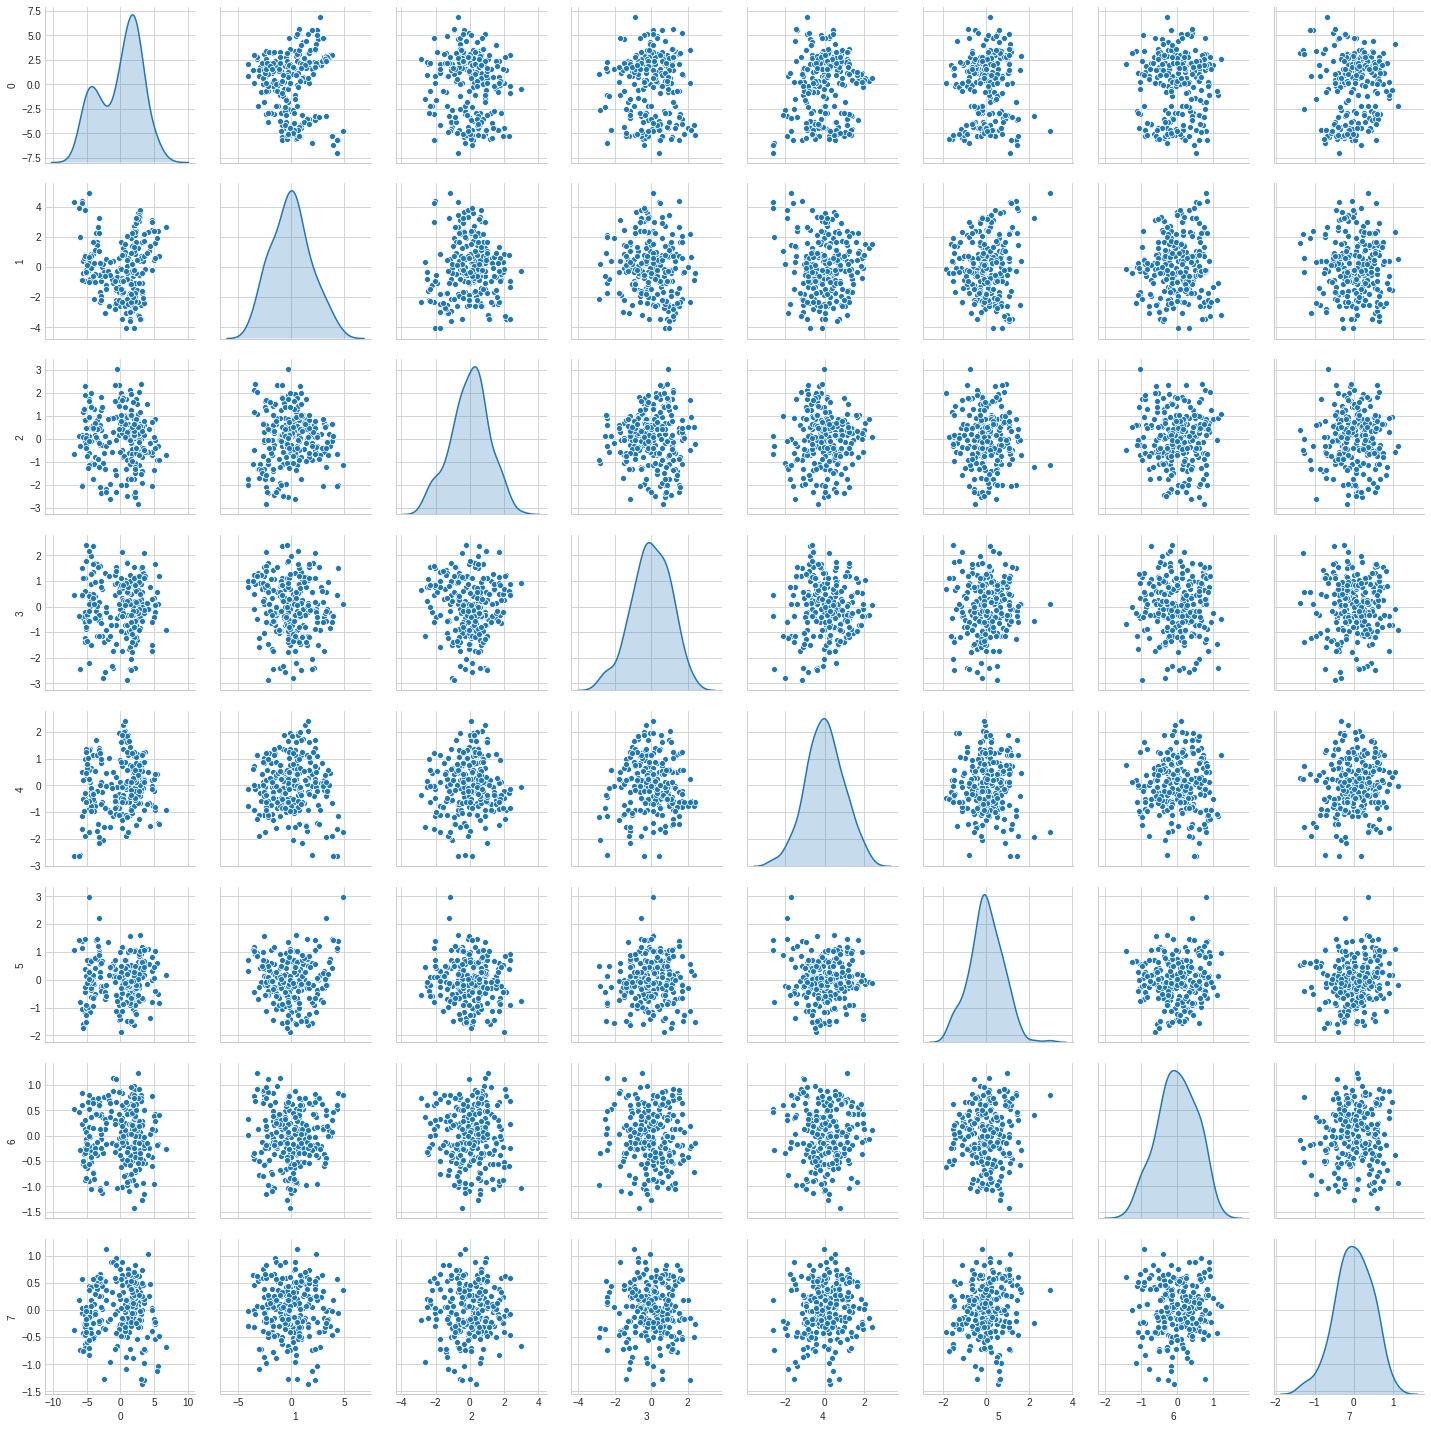

In [36]:
sns.pairplot(Projected_df_test, diag_kind='kde')

**After dimensionality reduction using PCA our attributes have become independent with no correlation among themselves. As most of them have cloud of data points with no linear kind of relationship.**

# Fitting SVC model On Original Data:

In [37]:
clf1 = SVC()
clf1.fit(X_train, y_train)
print ('Before PCA score', clf1.score(X_test, y_test))
clf2 = SVC()
clf2.fit(X_train_pca, y_train)
print ('After PCA score', clf2.score(X_test_pca, y_test))
#print("Before PCA On Original 18 Dimension",accuracy_score(Orig_y_test,Orig_y_predict))
#print("After PCA(On 8 dimension)",accuracy_score(pca_y_test,pca_y_predict))
#predict the y value
pca_yhat_predict= clf2.predict(X_test_pca)
#orginal data yhat value
orig_yhat_predict = clf1.predict(X_test)
print("Before PCA On Original 18 Dimension",accuracy_score(y_test,orig_yhat_predict))
print("After PCA(On 8 dimension)",accuracy_score(y_test,pca_yhat_predict))

Before PCA score 0.9631147540983607
After PCA score 0.9467213114754098
Before PCA On Original 18 Dimension 0.9631147540983607
After PCA(On 8 dimension) 0.9467213114754098


**Summary**
* On training data set we saw that our support vector classifier without performing PCA has an accuracy score of 96 %
* But when we applied the SVC model on PCA components(reduced dimensions) our model scored 94 %.
* Considering that original dataframe had 18 dimensions and After PCA dimension reduced to 8, our model has performed well in terms of accuracy score.

# Confusion matrix

In [0]:
def confmatrix(y_test, yhat, str1, str2, str3, datatype ):
    #Make predictions and evaluate
    #model_pred = fit_test_model(model,X_train, y_train, X_test)
    cm = confusion_matrix( y_test, yhat, [0,1,2] )
    print("Confusion Matrix For :", "\n",datatype,cm )

In [39]:
confmatrix(y_test, orig_yhat_predict,"Van ", "Car ", "Bus", "Original Data Set" )
confmatrix(y_test, pca_yhat_predict,"Van ", "Car ", "Bus", "For Reduced Dimensions Using PCA ")
#Classification Report Of Model built on Raw Data
print("Classification Report For Raw Data:", "\n", classification_report(y_test,orig_yhat_predict))
#Classification Report Of Model built on Principal Components:
print("Classification Report For PCA:","\n", classification_report(y_test,pca_yhat_predict))

Confusion Matrix For : 
 Original Data Set [[ 62   1   0]
 [  0 119   3]
 [  0   5  54]]
Confusion Matrix For : 
 For Reduced Dimensions Using PCA  [[ 61   2   0]
 [  0 119   3]
 [  0   8  51]]
Classification Report For Raw Data: 
               precision    recall  f1-score   support

           0       1.00      0.98      0.99        63
           1       0.95      0.98      0.96       122
           2       0.95      0.92      0.93        59

    accuracy                           0.96       244
   macro avg       0.97      0.96      0.96       244
weighted avg       0.96      0.96      0.96       244

Classification Report For PCA: 
               precision    recall  f1-score   support

           0       1.00      0.97      0.98        63
           1       0.92      0.98      0.95       122
           2       0.94      0.86      0.90        59

    accuracy                           0.95       244
   macro avg       0.96      0.94      0.94       244
weighted avg       0.95     

**From the above confusion matrix and classification report it is clear that the model performs well after the reduced dimensions**

# 4. Use Support vector machines and use grid search (try C values - 0.01, 0.05, 0.5, 1 and kernel  = linear, rbf) and find out the best hyperparameters and do cross-validation to find the accuracy.  (10 points)

**Hyperparamter Tuning :Using GridSearchCV & Cross-Validation:**

In [0]:
import itertools
def classifiers_hypertune(name,rf,param_grid,X_train,y_train,X_test,y_test,CV):
    CV_rf = GridSearchCV(estimator=rf, param_grid=param_grid, cv=CV, verbose= 1, n_jobs =-1 )
    CV_rf.fit(X_train, y_train)
    
    y_pred_train = CV_rf.predict(X_train)
    y_pred_test = CV_rf.predict(X_test)
    
    print('Best Score: ', CV_rf.best_score_)
    print('Best Params: ', CV_rf.best_params_)
    
    
    
    #Classification Report
    print(name+" Classification Report: ")
    print(classification_report(y_test, y_pred_test))
    
   
    #Confusion Matrix for test data
    confmatrix(y_test, y_pred_test,"Van", "Car", "Bus", "Original Data Set" )
    print("SVM Accuracy Score:",round(accuracy_score(y_test, y_pred_test),2)*100)

In [0]:
#Training on SVM Classifier
from sklearn.model_selection import GridSearchCV
svmc = SVC()

##param grid
param_grid = [
  {'C': [ 0.01, 0.05, 0.5, 1 ], 'kernel': ['linear']},
  {'C': [0.01, 0.05, 0.5, 1],  'kernel': ['rbf']},
 ]

**On PCA data**

In [42]:
classifiers_hypertune("Support Vector Classifier", svmc, param_grid,X_train_pca, y_train, X_test_pca, y_test,10)

Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Best Score:  0.9525483304042179
Best Params:  {'C': 1, 'kernel': 'rbf'}
Support Vector Classifier Classification Report: 
              precision    recall  f1-score   support

           0       1.00      0.97      0.98        63
           1       0.92      0.98      0.95       122
           2       0.94      0.86      0.90        59

    accuracy                           0.95       244
   macro avg       0.96      0.94      0.94       244
weighted avg       0.95      0.95      0.95       244

Confusion Matrix For : 
 Original Data Set [[ 61   2   0]
 [  0 119   3]
 [  0   8  51]]
SVM Accuracy Score: 95.0


[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    2.5s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Using the best hyper parameters {'C': 1, 'kernel': 'rbf'} found using grid search on PCA reduced data model accuracy improved at 95% from 94

**On Original data**

In [43]:
classifiers_hypertune("Support Vector Classifier", svmc, param_grid,X_train, y_train, X_test, y_test,10)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 10 folds for each of 8 candidates, totalling 80 fits
Best Score:  0.9718804920913884
Best Params:  {'C': 1, 'kernel': 'rbf'}
Support Vector Classifier Classification Report: 
              precision    recall  f1-score   support

           0       1.00      0.98      0.99        63
           1       0.95      0.98      0.96       122
           2       0.95      0.92      0.93        59

    accuracy                           0.96       244
   macro avg       0.97      0.96      0.96       244
weighted avg       0.96      0.96      0.96       244

Confusion Matrix For : 
 Original Data Set [[ 62   1   0]
 [  0 119   3]
 [  0   5  54]]
SVM Accuracy Score: 96.0


[Parallel(n_jobs=-1)]: Done  77 out of  80 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    0.8s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Using the best hyper parameters {'C': 1, 'kernel': 'rbf'} found using grid search on original data,model accuracy has improved to 97% from 96

# SUMMARY :

* Treated missing values and outliers.
* Found strong co-relation between every independent attributes resulting in multi-colineraity problem.
* Used the normalized or scaled data on PCA for dimensionality reduction after which the model performed well.
* Used hyperparameter tuning techniques which tunes the model performances and also employs Cross-fold validation internally to make sure our model performs better than that of after the dimensional reduction.